# Libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import joblib
from joblib import dump, load
from scipy import sparse

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# File Imports

In [2]:
books=pd.read_csv("/kaggle/input/book-recommendation-dataset/Books.csv",low_memory=False,index_col="ISBN")
ratings=pd.read_csv("/kaggle/input/book-recommendation-dataset/Ratings.csv")

In [3]:
books.head()

,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
ISBN,,,,,,,
0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [4]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [5]:
books=books.drop(["Image-URL-M","Image-URL-S"],axis=1)

In [6]:
final_ratings = ratings.groupby('ISBN').agg({
    'Book-Rating': ['count', 'mean']
})
final_ratings.columns = ['rating_count', 'avg_rating']
final_ratings.head()

,rating_count,avg_rating
ISBN,,
0330299891,2,3.0
0375404120,2,1.5
0586045007,1,0.0
9022906116,2,3.5
9032803328,1,0.0


# EDA

In [7]:
print("Data Shape")
final_ratings.shape,books.shape

Data Shape


((340556, 2), (271360, 5))

In [8]:
final_ratings.avg_rating.value_counts()

avg_rating
0.000000     154583
8.000000      19105
5.000000      18320
10.000000     16762
7.000000      15543
              ...  
2.517986          1
2.228070          1
1.743363          1
0.877551          1
5.687500          1
Name: count, Length: 3806, dtype: int64

In [9]:
final_ratings[final_ratings.rating_count>10].avg_rating.value_counts()

avg_rating
3.000000    263
2.000000    241
4.000000    135
0.000000    124
2.500000    104
           ... 
2.517986      1
2.228070      1
1.743363      1
0.877551      1
5.687500      1
Name: count, Length: 3722, dtype: int64

In [10]:
(final_ratings[(final_ratings.rating_count>10)&(final_ratings.avg_rating==0)]).shape

(124, 2)

In [11]:
final_ratings.avg_rating.round().value_counts()

avg_rating
0.0     155205
4.0      26423
2.0      24781
5.0      23143
8.0      21978
3.0      20487
10.0     17421
7.0      16765
6.0      13116
9.0      12713
1.0       8524
Name: count, dtype: int64

In [12]:
final_ratings["rounded_rating"]=final_ratings.avg_rating.round()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


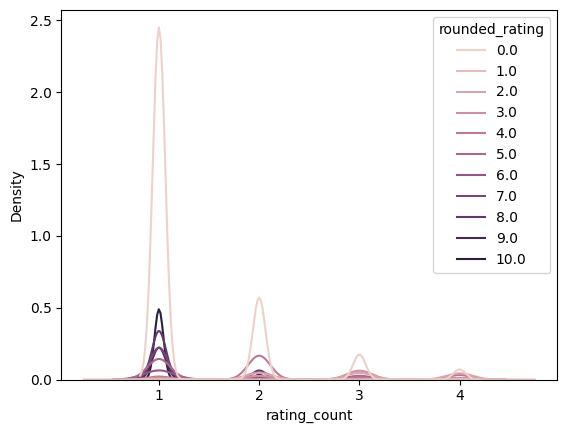

In [13]:
sns.kdeplot(data=final_ratings[final_ratings.rating_count<5],x="rating_count",hue="rounded_rating")
plt.show()

# Feature Engineering

In [14]:
final_ratings=final_ratings[(final_ratings.rating_count>5)]

In [15]:
final_ratings.shape

(34757, 3)

In [16]:
books_data=books.merge(final_ratings,on="ISBN")
books_data.shape

(32737, 8)

In [17]:
books_data.head()

,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L,rating_count,avg_rating,rounded_rating
ISBN,,,,,,,,
0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,14,4.928571,5.0
0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,11,4.272727,4.0
0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,33,4.212121,4.0
0771074670,Nights Below Station Street,David Adams Richards,1988,Emblem Editions,http://images.amazon.com/images/P/0771074670.0...,6,1.000000,1.0
1558746218,A Second Chicken Soup for the Woman's Soul (Ch...,Jack Canfield,1998,Health Communications,http://images.amazon.com/images/P/1558746218.0...,8,3.375000,3.0


In [18]:
book_description_columns=["Book-Title","Book-Author","Publisher"]
books_data["Book_Details"]=""
for col in book_description_columns:
    books_data["Book_Details"]+=books_data[col]+" "

In [19]:
def save_tfidf(tfidf_matrix,vectorizer,feature_names):
    sparse.save_npz('tfidf_matrix.npz', tfidf_matrix)
    joblib.dump(vectorizer, 'tfidf_vectorizer.joblib')
    np.save('feature_names.npy', feature_names)

In [20]:
def compute_and_save_tfidf(data,column,vectorizer):
    tfidf_matrix = vectorizer.fit_transform(data[column])
    feature_names = vectorizer.get_feature_names_out()
    save_tfidf(tfidf_matrix,vectorizer,feature_names)
    return pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

In [21]:
books

,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L
ISBN,,,,,
0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...
0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...
0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...
0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...
0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...
...,...,...,...,...,...
0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),http://images.amazon.com/images/P/0440400988.0...
0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,http://images.amazon.com/images/P/0525447644.0...
006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco,http://images.amazon.com/images/P/006008667X.0...


In [22]:
stop_words = stopwords.words('english')
vectorizer=TfidfVectorizer(
    stop_words=stop_words,
    lowercase=True,
    max_features=10000, 
)


In [23]:
vectorized_dataframe=compute_and_save_tfidf(books_data,"Book_Details",vectorizer)

In [24]:
vectorized_dataframe.index=books_data.index

In [25]:
vectorized_dataframe.head()

,000,01,02,03,04,05,08,10,100,1000,...,zweigniederlassung,zz,zã,â¼bbe,â¼ber,â¼cher,â¼gen,â¼nfte,â¼r,â¼rich
ISBN,,,,,,,,,,,,,,,,,,,,,
0002005018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0374157065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0399135782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0771074670,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1558746218,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
books_data.to_csv("books_data.csv")